In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras import layers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import warnings
import pdb

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')

keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2023-03-14 16:59:21.884775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:23.260092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/envs/tf/lib/:/home/ubuntu/miniconda3/envs/tf/lib/
2023-03-14 16:59:23.260179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/envs/tf/lib/:/home/ubuntu/mini

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3337555276984632413
xla_global_id: -1
]


2023-03-14 16:59:25.124905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:25.143655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-14 16:59:25.143687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu-ASUS-TUF-Gaming-A15-FA506II-FA566II
2023-03-14 16:59:25.143694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu-ASUS-TUF-Gaming-A15-FA506II-FA566II
2023-03-14 16:59:25.143806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-03-14 16:59:25.14

In [2]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


In [3]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [4]:
DATAPATH = './dataset'
OUTPATH = './output'
CATEGORIES = ('no', 'sphere', 'vort')

In [5]:
def load_data(root, datatype, categories):
    x, y = [], []
    num_classes = len(categories)
    for index, category in enumerate(categories):
        category_path = os.path.join(root, datatype, category)
        for filename in os.scandir(category_path):
            filedata = np.load(filename.path)
            x.append(filedata)

            label = np.stack([np.eye(num_classes)[index]
                              for i in range(len(filedata))], axis=0)
            y.append(label)
    x = np.expand_dims(np.concatenate(x, axis=0), axis=-1)
    y = np.concatenate(y, axis=0)

    np.save(os.path.join(root, f'X_{datatype}.npy'), x)
    np.save(os.path.join(root, f'Y_{datatype}.npy'), y)

    return x, y

In [6]:
X_TRAIN, Y_TRAIN = load_data(DATAPATH, 'train', CATEGORIES)
print(f'X_TRAIN Shape: {X_TRAIN.shape}')
print(f'Y_TRAIN Shape: {Y_TRAIN.shape}')

X_VAL, Y_VAL = load_data(DATAPATH, 'val', CATEGORIES)
print(f'X_VAL shape: {X_VAL.shape}')
print(f'Y_VAL Shape: {Y_VAL.shape}')

X_TRAIN Shape: (30000, 150, 150, 1)
Y_TRAIN Shape: (30000, 3)
X_VAL shape: (7500, 150, 150, 1)
Y_VAL Shape: (7500, 3)


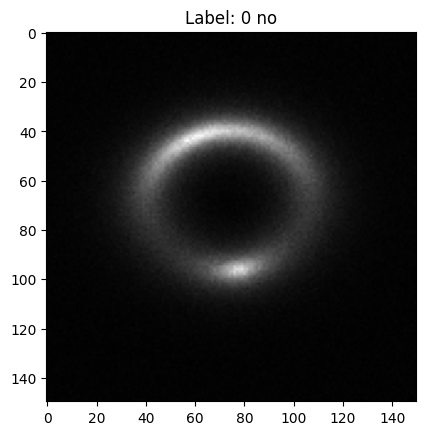

In [7]:
index = np.random.default_rng().integers(5, len(X_TRAIN))
a = plt.imshow(X_TRAIN[index+2].squeeze(), cmap='gray')
label = np.argmax(Y_TRAIN[index+2])
a1 = plt.title(f'Label: {label} {CATEGORIES[label]}')

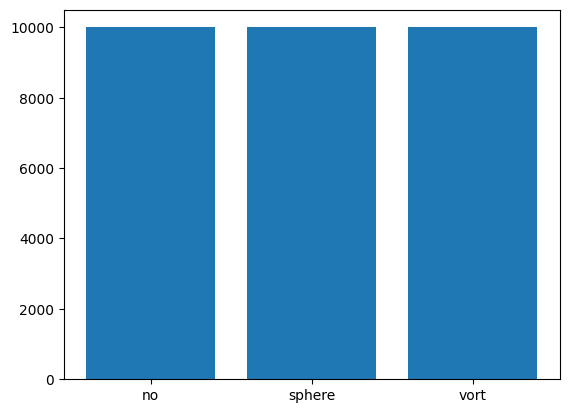

In [8]:
labels = np.argmax(Y_TRAIN, axis=1)
class_sizes = [len(labels[labels == index]) for index in range(len(CATEGORIES))]

fig, axis = plt.subplots()
b = axis.bar(range(len(CATEGORIES)), class_sizes, tick_label=CATEGORIES)

In [9]:
def standardize(x, datatype, root):
    x = ((x - np.mean(x, axis=(1, 2), keepdims=True)) / np.std(x, axis=(1, 2), keepdims=True))
    return x

In [10]:
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
X_VAL = standardize(X_VAL, 'val', OUTPATH)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    m = keras.Sequential([layers.RandomFlip(), layers.RandomRotation(0.5), RandomZoom(height_factor=0.2, width_factor=0.2) ],
                          name='augment')(inputs)

    m = layers.Conv2D(16, 5)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)

    for _ in range(3):
        m = layers.Conv2D(32, 3)(m)
        m = layers.BatchNormalization()(m)
        m = layers.Activation('relu')(m)
        m = layers.MaxPool2D()(m)

    for _ in range(2):
        residual = layers.Conv2D(64, 1)(m)
        m = layers.Conv2D(64, 3, padding='same')(m)
        m = layers.BatchNormalization()(m)
        m = layers.Activation('relu')(m)
        m = layers.add([m, residual]) # Residual connection

    m = layers.Conv2D(128, 3)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)

    m = layers.Flatten()(m)

    m = layers.Dense(256, activation='relu')(m)
    m = layers.Dense(32, activation='relu')(m)

    outputs = layers.Dense(num_classes, activation='softmax')(m)

    return keras.Model(inputs, outputs)

In [12]:
class RandomSampleGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size, seed=None):
        self.labels = np.argmax(y, axis=1)
        self.classes = np.unique(labels)
        self.x = [x[labels == class_] for class_ in self.classes]
        self.y = [y[labels == class_] for class_ in self.classes]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        num_classes = len(self.classes)
        for class_ in range(num_classes):
            indices = self.rng.choice(self.x[class_].shape[0],
                                      self.batch_size // num_classes,
                                      replace=False)
            batch_x.append(self.x[class_][indices])
            batch_y.append(self.y[class_][indices])

        batch_x = np.concatenate(batch_x)
        batch_y = np.concatenate(batch_y)

        return batch_x, batch_y

In [13]:
class TrackBestPerformance(keras.callbacks.Callback):
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')

In [14]:
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 5e-4



In [15]:
model = make_model(X_TRAIN.shape[1:], len(CATEGORIES))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=keras.metrics.AUC(multi_label=True, num_labels=3, name='auc'), 
              run_eagerly=False)


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 150, 150, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 146, 146, 16  416         ['augment[0][0]']                
                                )                                                                 
                                                                                              

In [17]:
data_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN,
                                        batch_size=BATCH_SIZE, seed=42)

history = model.fit(data_generator, validation_data=(X_VAL, Y_VAL),
                        epochs=EPOCHS, verbose=2)

Epoch 1/30


2023-03-14 17:12:50.842484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 675000000 exceeds 10% of free system memory.
2023-03-14 17:12:51.467026: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 675000000 exceeds 10% of free system memory.


234/234 - 664s - loss: 1.1769 - auc: 0.5051 - val_loss: 1.1126 - val_auc: 0.5026 - 664s/epoch - 3s/step
Epoch 2/30
234/234 - 635s - loss: 1.1157 - auc: 0.5069 - val_loss: 1.1057 - val_auc: 0.5245 - 635s/epoch - 3s/step
Epoch 3/30
234/234 - 626s - loss: 1.1050 - auc: 0.5102 - val_loss: 1.0977 - val_auc: 0.5293 - 626s/epoch - 3s/step
Epoch 4/30
234/234 - 623s - loss: 1.0994 - auc: 0.5197 - val_loss: 1.1014 - val_auc: 0.5274 - 623s/epoch - 3s/step
Epoch 5/30
234/234 - 622s - loss: 1.0976 - auc: 0.5293 - val_loss: 1.1215 - val_auc: 0.5409 - 622s/epoch - 3s/step
Epoch 6/30
234/234 - 619s - loss: 1.0954 - auc: 0.5327 - val_loss: 1.1044 - val_auc: 0.5418 - 619s/epoch - 3s/step
Epoch 7/30
234/234 - 618s - loss: 1.0919 - auc: 0.5455 - val_loss: 1.1756 - val_auc: 0.5586 - 618s/epoch - 3s/step
Epoch 8/30
234/234 - 620s - loss: 1.0909 - auc: 0.5450 - val_loss: 1.0921 - val_auc: 0.5620 - 620s/epoch - 3s/step
Epoch 9/30
234/234 - 618s - loss: 1.0885 - auc: 0.5498 - val_loss: 1.0869 - val_auc: 0.5773

In [18]:
best_epoch_index = np.argmax(history.history['val_auc'])

print('Best validation AUC: {:.3%}'.format(history.history['val_auc'][best_epoch_index]))
print('Corresponding train AUC: {:.3%}'.format(history.history['auc'][best_epoch_index]))

Best validation AUC: 97.425%
Corresponding train AUC: 97.165%


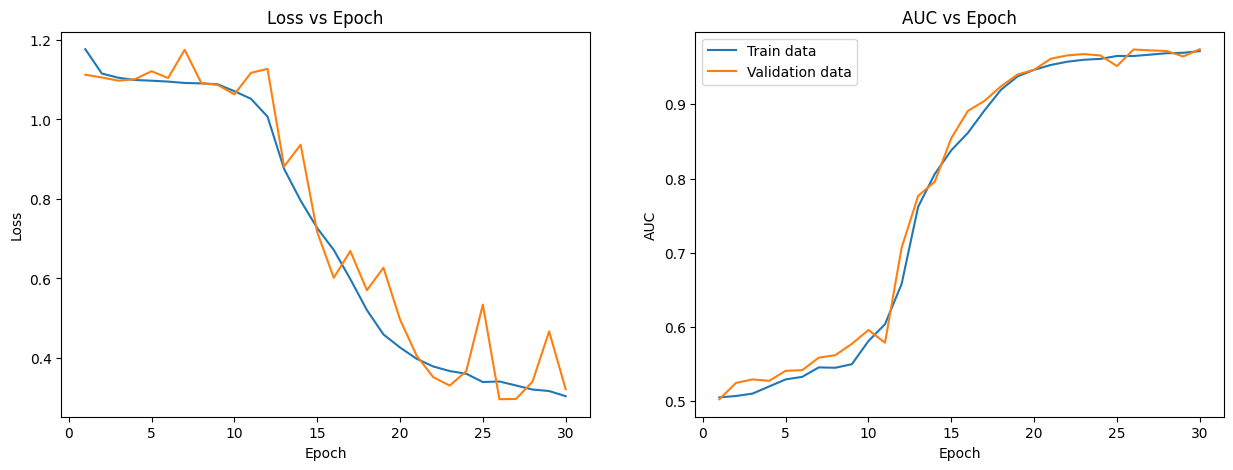

In [19]:

p1, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

p2 = axes[0].plot(range(1, best_epoch_index + 2),
                     history.history['loss'][:best_epoch_index + 1],
                     label='Train data')
p3 = axes[0].plot(range(1, best_epoch_index + 2),
                     history.history['val_loss'][:best_epoch_index + 1],
                     label='Validation data')
p4 = axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')
    
p5 = axes[1].plot(range(1, best_epoch_index + 2),
                     history.history['auc'][:best_epoch_index + 1],
                     label='Train data')
p6 = axes[1].plot(range(1, best_epoch_index + 2),
                     history.history['val_auc'][:best_epoch_index + 1],
                     label='Validation data')
p7 = axes[1].set(xlabel='Epoch', ylabel='AUC', title='AUC vs Epoch')

p8 = plt.legend()

In [20]:
!pushd {OUTPATH}; zip -rq weights.zip weights; popd

/bin/bash: /home/ubuntu/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
~/GSoC23/deeplense/output ~/GSoC23/deeplense
~/GSoC23/deeplense


In [21]:
def split_and_predict(x, num_batches=300):
    x_batches = np.array_split(x, num_batches)
    y_pred = np.concatenate([model(x_batch).numpy() for x_batch in x_batches], axis=0)
    return y_pred

In [22]:
Y_PRED_TRAIN = split_and_predict(X_TRAIN)
Y_PRED_VAL = split_and_predict(X_VAL)

In [25]:
def plot_roc_curve(y, y_pred, categories, axis, num_thresholds=200):
    thresholds = np.linspace(0., 1., num_thresholds)

    trp, falp, trn, faln = [], [], [], []

    for threshold in thresholds:
        y_pred_label = (y_pred > threshold).astype(int)
        trp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
        falp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
        trn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
        faln.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

    trp, falp, trn, faln = np.array(trp), np.array(falp), np.array(trn), np.array(faln)

    trp_rate = trp / (trp + faln)
    falp_rate = falp / (falp + trn)

    for index, category in enumerate(categories):
        p9 = axis.plot(falp_rate[:, index], trp_rate[:, index], label=category)

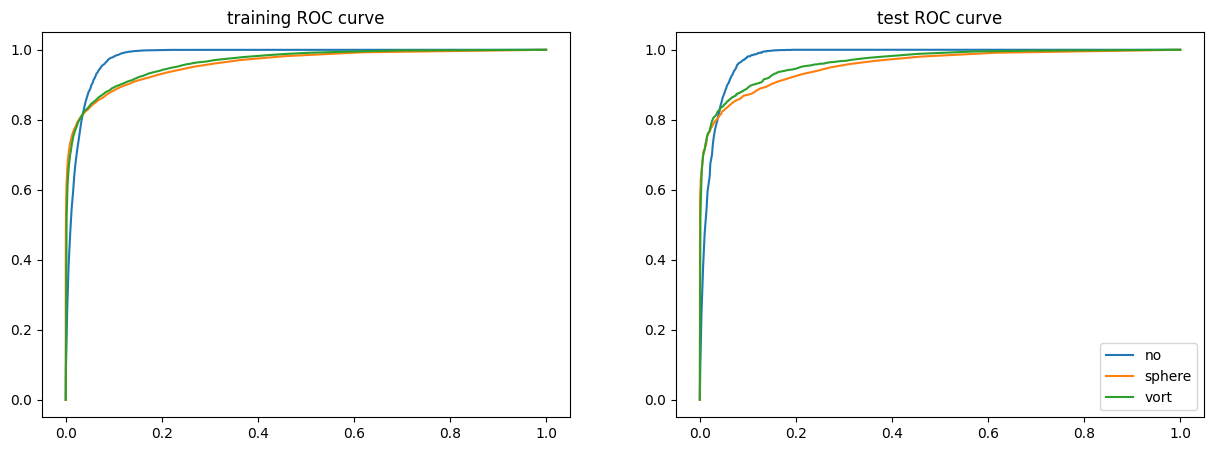

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plot_roc_curve(Y_TRAIN, Y_PRED_TRAIN, CATEGORIES, axes[0])
p10 = axes[0].set(title='training ROC curve')

plot_roc_curve(Y_VAL, Y_PRED_VAL, CATEGORIES, axes[1])
p11 = axes[1].set(title='test ROC curve')

p12 = plt.legend()